# Multi-GPU training and hyperparameter optimisation with PyTorch Lightning and Optuna

<img src="https://images.unsplash.com/photo-1582854050148-651d87fa3319?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=1950&q=80">
Image from Unsplash by Gustavo Campos

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

from pytorch_lightning.core.lightning import LightningModule 
from pytorch_lightning.core.datamodule import LightningDataModule
from pytorch_lightning.trainer.trainer import Trainer

from torchvision.datasets import MNIST
from torchvision import datasets, transforms

import json
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings("ignore")
from os import listdir
from os.path import join

pl.seed_everything(17)

Global seed set to 17


17

In [2]:
print("Available gpus: {}".format(torch.cuda.is_available()))

for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

Available gpus: True
GeForce RTX 2080
GeForce RTX 2080


## Data Lookup

In [3]:
DATA_PATH = "/Datasets/Intel_Image_Classification"

CLASSES = {0 : 'sea', 
           1 : 'street', 
           2 : 'glacier', 
           3 : 'forest', 
           4 : 'buildings', 
           5 : 'mountain'}

In [4]:
def GetIntelImages(data_dir, class_dict):
    """
    Function that reads intel image classification data.
    
    Inputs:
    data_dir : path to root folder of the dataset
    class_dict : {1: class_1, 2: class_2, ...}
    
    Outputs:
    train_list, test_list, class_dict
    
    train_list(test_list) : 
    list , element - (np.array(width, height, color_channels), numerical label)    
    """
    
    train_fnames = dict([(c, []) for c in class_dict])
    for c in class_dict:
        path = join(DATA_PATH, "seg_train", "seg_train", c)
        for f in listdir(path):
            train_fnames[c].append(join(path, f))

    print(f"Training set has {sum((len(v) for k, v in train_fnames.items()) )} images.")

    test_fnames = dict([(c, []) for c in class_dict])
    for c in class_dict:
        path = join(DATA_PATH, "seg_test", "seg_test", c)
        for f in listdir(path):
            test_fnames[c].append(join(path, f))
            
    print(f"Test set has {sum((len(v) for k, v in train_fnames.items()) )} images.")
    
    train_data = []

    for key, fnames in train_fnames.items():
        for fname in fnames:
            train_data.append((np.asarray(Image.open(fname)), class_dict[key]))

    test_data = []

    for key, fnames in test_fnames.items():
        for fname in fnames:
            test_data.append((np.asarray(Image.open(fname)), class_dict[key]))
            
            
    return train_data, test_data

In [5]:
INV_CLASSES = dict([(v, k) for k, v in CLASSES.items()])

train, test = GetIntelImages(DATA_PATH, INV_CLASSES)

train[0][0].shape

Training set has 14034 images.
Test set has 14034 images.


(150, 150, 3)

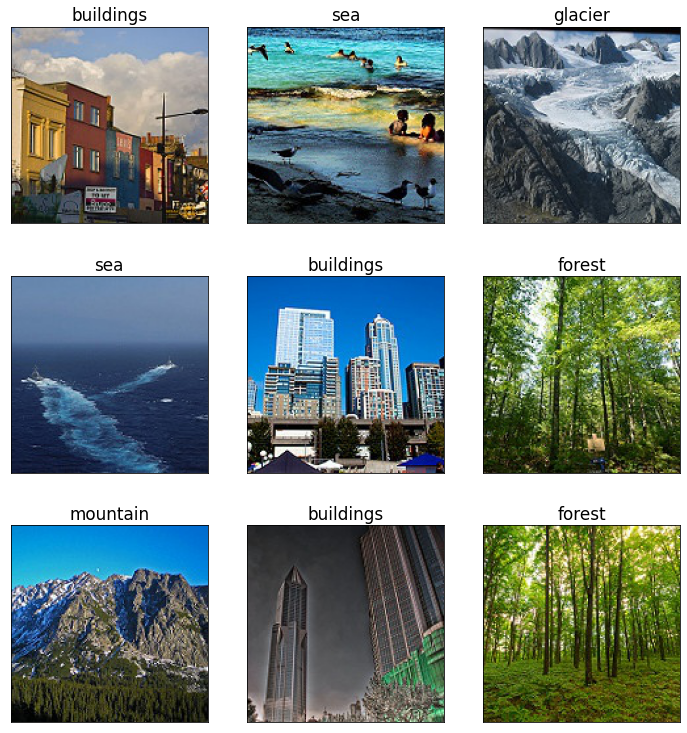

In [6]:
nrows = 3
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 13))

idxs = np.random.choice(len(train), 9)

for i, idx in enumerate(idxs):
    c = i // 3
    r = i - nrows * c
    axs[r, c].imshow(train[idx][0])
    axs[r, c].set_xticks([])
    axs[r, c].set_yticks([])
    axs[r, c].set_title(CLASSES[train[idx][1]])
    
plt.show()

In [7]:
from collections import Counter

cnt = Counter([img.shape for (img, lbl) in train])
cnt

Counter({(150, 150, 3): 13986,
         (113, 150, 3): 7,
         (140, 150, 3): 1,
         (146, 150, 3): 2,
         (111, 150, 3): 3,
         (102, 150, 3): 1,
         (143, 150, 3): 2,
         (149, 150, 3): 1,
         (135, 150, 3): 3,
         (119, 150, 3): 1,
         (97, 150, 3): 1,
         (76, 150, 3): 1,
         (123, 150, 3): 2,
         (110, 150, 3): 1,
         (142, 150, 3): 2,
         (120, 150, 3): 1,
         (105, 150, 3): 1,
         (134, 150, 3): 2,
         (108, 150, 3): 2,
         (115, 150, 3): 1,
         (133, 150, 3): 1,
         (136, 150, 3): 2,
         (124, 150, 3): 1,
         (144, 150, 3): 2,
         (100, 150, 3): 1,
         (147, 150, 3): 1,
         (131, 150, 3): 1,
         (81, 150, 3): 1,
         (145, 150, 3): 1,
         (141, 150, 3): 1,
         (103, 150, 3): 1})

## Benchmark Model

In [8]:
class IntelDataModule(LightningDataModule):
    def __init__(self, train_data : list, test_data : list, batch_size: int = 64):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.prep = transforms.Compose([transforms.Resize(size=(150, 150)), 
                                        transforms.ToTensor()])
        self.aug = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5)])
        
    def setup(self, stage=None):
        # Preprocess and split.
        train = [(self.prep(Image.fromarray(x).copy()), y) for (x, y) in self.train_data]            
        self.test  = [(self.prep(Image.fromarray(x).copy()), y) for (x, y) in self.test_data]
        split = int(0.8 * len(train))
        self.train, self.val = random_split(train, [split, len(train) - split])
    
    
    def train_dataloader(self):        
        return DataLoader([(self.aug(x), y) for (x, y) in self.train], 
                          shuffle = True, batch_size=self.batch_size)

    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)

    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)

In [9]:
data = IntelDataModule(train, test)
data.setup()
print("train set length {}\nvalidation set length {}".format(len(data.train), len(data.val)))

train set length 11227
validation set length 2807


In [10]:
class Conv2d_ext(nn.Module):
    """
    Conv2D with activation function, optional batch norm and auto-padding
    """
    def __init__(self, inp_C, out_C, kernel_size = 3, stride = 1, batch_norm=True):
        super(Conv2d_ext, self).__init__()
        # with stride = 1 heigh and width of input and output are equal
        padding_size = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(inp_C, out_C, kernel_size=kernel_size, stride=stride, 
                            padding=padding_size)
        self.bn1 = nn.BatchNorm2d(out_C) if batch_norm else nn.Sequential()
        self.a1 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.a1(x)
        
        return x

In [11]:
class Benchmark(LightningModule):
    def __init__(self):
        super(Benchmark, self).__init__()
        channels = [3, 64, 64, 128, 128, 256, 256, 512, 6]
        
        layers = [nn.Sequential(Conv2d_ext(inp_C, out_C, stride=2), nn.Dropout(0.1)) 
                                     for (inp_C, out_C) in zip(channels[:-1], channels[1:-1])]
        
        layers += [Conv2d_ext(channels[-2], channels[-1], stride=2)]
        
        self.layers = nn.Sequential(*layers)
        self.train_metric = pl.metrics.Accuracy(compute_on_step=False)
        self.valid_metric = pl.metrics.Accuracy(compute_on_step=False)
        
        
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze()
        
        x = F.log_softmax(x, dim=1)
        
        return x

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=0.0)
    
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.train_metric(logits, y)
        return {'loss' : loss}
  
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.valid_metric(logits, y)
        return {'loss' : loss}
     
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
    
    
    def training_epoch_end(self, outputs):
        loss = sum([out['loss'] for out in outputs])/len(outputs)
        self.log_dict({'train_loss' : loss.detach(), 
               'train_accuracy' : self.train_metric.compute()})
        
    def validation_epoch_end(self, outputs):
        loss = sum([out['loss'] for out in outputs])/len(outputs)
        self.log_dict({'val_loss' : loss.detach(), 
               'val_accuracy' : self.valid_metric.compute()})
    
    def test_epoch_end(self, outputs):
        loss = sum([out['loss'] for out in outputs])/len(outputs)
        self.log_dict({'test_loss' : loss.detach(), 
               'test_accuracy' : self.valid_metric.compute()})

In [12]:
# Test model
test_image = torch.rand(10, 3, 150, 150)

test_model = Benchmark()

test_model(test_image).shape

torch.Size([10, 6])

In [13]:
logger = pl.loggers.TensorBoardLogger('bmark_logs', name='intl_clf')

model = Benchmark()

data = IntelDataModule(train, test)

early_stop = pl.callbacks.EarlyStopping('val_loss', patience=4)

trainer = Trainer(logger=logger,
                  gpus=1,
                  max_epochs=20, 
                  deterministic=True,
                  callbacks = [early_stop])

trainer.fit(model, data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | layers       | Sequential | 2.4 M 
1 | train_metric | Accuracy   | 0     
2 | valid_metric | Accuracy   | 0     
--------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [14]:
trainer.test()
None

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': tensor(0.8213, device='cuda:0'),
 'test_loss': tensor(0.6497, device='cuda:0')}
--------------------------------------------------------------------------------


In [15]:
# Inference from the benchmark model
model.eval()

tgt_true = []
tgt_pred = []

for batch in data.test_dataloader():
    pred_stack = model(batch[0].to('cuda:0'))
    tgt_pred += torch.argmax(pred_stack, dim=1).tolist()
    tgt_true += batch[1].tolist()

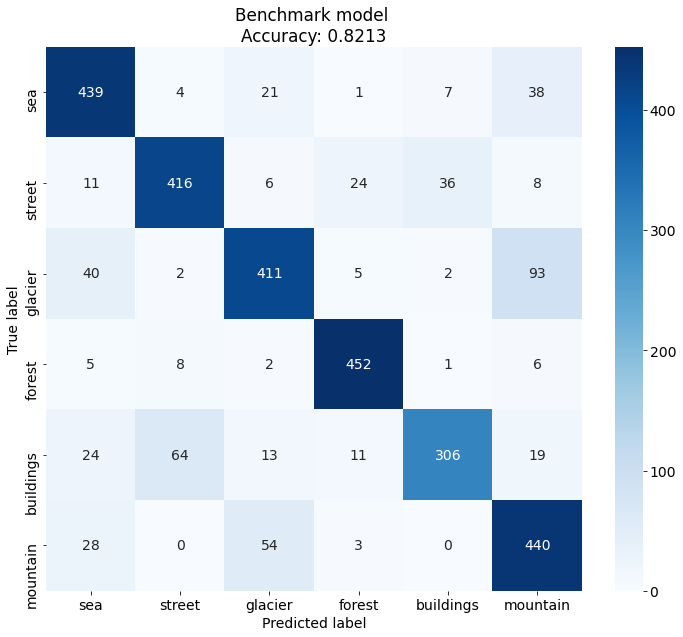

In [16]:
cm = plt.get_cmap('Blues')

# Creates a confusion matrix
cnf_matr = confusion_matrix(tgt_true, tgt_pred) 

# Transform to df for easier plotting
df = pd.DataFrame(cnf_matr, index=list(CLASSES.values()), columns=list(CLASSES.values()) )

plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=True, fmt="d", cmap=cm)
plt.title('Benchmark model \nAccuracy: {0:.4f}'.format(accuracy_score(tgt_true, tgt_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Multi-GPU training and hyperparameter optimization

In [17]:
class Model(LightningModule):
    def __init__(self, inp_C=3, inp_C_bbone = 32, out_C_bbone = 32, 
                 backbone=nn.Sequential(nn.ReLU()), learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        
        #self.inp = nn.Sequential(Conv2d_ext(inp_C, inp_C_bbone, stride=2), nn.Dropout(0.1))
        self.inp = nn.Conv2d(inp_C, inp_C_bbone, kernel_size=(3,3), padding=3, stride=2)
        self.backbone = backbone        
        self.out = nn.Conv2d(out_C_bbone, 6, kernel_size=(3,3))
        
        self.train_metric = pl.metrics.Accuracy(compute_on_step=False)
        self.valid_metric = pl.metrics.Accuracy(compute_on_step=False)
        
        
    def forward(self, x):
        x = self.inp(x)
        x = self.backbone(x)
        x = self.out(x).squeeze()

        x = F.log_softmax(x, dim=1)
        return x

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.001)
    
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return {'loss' : loss, 'logits' : logits, 'y' : y}

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)
      
    def test_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx)
    
    
    def training_step_end(self, outputs):
        loss = outputs['loss'].mean()
        self.train_metric(outputs['logits'], outputs['y'])
        return {'loss' : loss}
    
    def validation_step_end(self, outputs):
        loss = outputs['loss'].mean()
        self.valid_metric(outputs['logits'], outputs['y'])
        return {'loss' : loss}
    
    def test_step_end(self, outputs):
        return self.validation_step_end(outputs)
    

    def training_epoch_end(self, outputs):
        loss = sum([out['loss'] for out in outputs])/len(outputs)
        self.log_dict({'loss' : {"train" : loss.detach()}, 
               'accuracy' : {"train" : self.train_metric.compute()}})
        
    def validation_epoch_end(self, outputs, mode: str="valid"):
        loss = sum([out['loss'] for out in outputs])/len(outputs)
        self.log_dict({'loss' : {mode : loss.detach()}, 
               'accuracy' : {mode : self.valid_metric.compute()}})
        if mode == 'valid': self.log_dict({'call_loss' : loss.detach()})
    
    def test_epoch_end(self, outputs):
        self.validation_epoch_end(outputs, "test")

In [18]:
class Residual(nn.Module):
    """
    Residual module, similar to "Deep Residual Learning for Image Recognition"
    (https://arxiv.org/pdf/1512.03385.pdf)
    Skip connection is different though.
    """
    def __init__(self, inp_C, out_C, stride = 1, batch_norm=True):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(inp_C, out_C, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_C) if batch_norm else nn.Sequential()
        self.a1 = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_C, out_C, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_C) if batch_norm else nn.Sequential()
        
        changed_shape = (stride != 1) or (inp_C != out_C)
        
        self.skip = nn.Sequential(nn.Conv2d(inp_C, out_C, kernel_size=1, stride=stride), 
                                   nn.BatchNorm2d(out_C)) if changed_shape else nn.Sequential()

        self.a2 = nn.ReLU(inplace=True)
            
    def forward(self, inp):
        x = self.conv1(inp)
        x = self.bn1(x)
        x = self.a1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        return self.a2(x + self.skip(inp))

In [19]:
def conv_block(inp_C, out_C, block_type='Conv2d_ext', batch_norm = False, P_drp=0):
    """ Exch block halves the H and W of the input"""
    
    block = nn.ModuleDict({'Residual' : Residual(inp_C, out_C, stride=2, batch_norm=batch_norm), 
                           'Conv2d_ext' : Conv2d_ext(inp_C, out_C, stride=2, batch_norm=batch_norm)})
    
    optional = nn.Dropout(P_drp)# if dropout else nn.Sequential()
    
    return nn.Sequential(block[block_type], optional)

In [20]:
channels = [64, 128, 128, 256, 256, 512]

test_layers = [conv_block(inp_C, out_C, block_type='Residual', batch_norm=True, P_drp=0.1) 
               for (inp_C, out_C) in zip(channels, channels[1:])]

test_bbone = nn.Sequential(*test_layers)
              
test_model = Model(inp_C_bbone=channels[0], out_C_bbone=channels[-1], backbone=test_bbone)
              
test_image = torch.rand(10, 3, 150, 150)
              
test_model(test_image).shape

torch.Size([10, 6])

## Hyperparameter optimization setup

In [21]:
"""
backbone has a fixed number of blocks to get the size of an image 
"""
def create_backbone(trial):    
    inp_C = trial.suggest_int(f'inp_C_0', 32, 129)
    inp_C_bbone = inp_C    
    
    layers = []
    
    for n in range(5):
        out_C = trial.suggest_int(f'out_C_{n}', 32, 513)
        norm = trial.suggest_categorical(f'nrm_{n}', [True, False])
        block_type = trial.suggest_categorical(f'type_{n}', ['Conv2d_ext', 'Residual'])
        #dropout = trial.suggest_categorical(f'drp_{n}', [True, False])
        P_drp = trial.suggest_uniform(f'P_drp_{n}', 0, 0.3)
        
        layers.append(conv_block(inp_C, out_C, 
                                 block_type=block_type, 
                                 batch_norm=norm, 
                                 #dropout=dropout, 
                                 P_drp=P_drp))
        
        inp_C = out_C
    
    return nn.Sequential(*layers), inp_C_bbone, out_C

In [22]:
logger = pl.loggers.TensorBoardLogger('tb_logs', name='optuna')

data = IntelDataModule(train, test, batch_size=128)
data.setup()

train_data = data.train_dataloader()
val_data = data.val_dataloader()

def objective(trial):
    backbone, inp_C, out_C = create_backbone(trial)
    
    print(backbone)
    
    early_stop = pl.callbacks.EarlyStopping('call_loss', patience=4)
    
    model = Model(inp_C_bbone=inp_C, out_C_bbone=out_C, backbone=backbone)
    
     
    trainer = Trainer(logger=False, 
                      checkpoint_callback=False,
                      gpus=2,
                      accelerator='dp',
                      max_epochs=20, 
                      deterministic=True,
                      callbacks = [early_stop])
                      
    trainer.fit(model, train_data, val_data)
    
    score = trainer.test(model, val_data)
    
    return score[0]['accuracy']['test'].item()

In [23]:
sampler = optuna.samplers.TPESampler(seed=17)

study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.3 K 
1 | backbone     | Sequential | 8.0 M 
2 | out          | Conv2d     | 19.0 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params


Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(47, 422, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(422, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(422, 422, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(422, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(47, 422, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(422, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.020370107457387408, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(422, 310, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.03089815744203529, inplace=False)
  )
  (2): Sequential(
    (0): Resi

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.0 K 
1 | backbone     | Sequential | 2.7 M 
2 | out          | Conv2d     | 18.3 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7325, device='cuda:0')},
 'loss': {'test': tensor(0.9372, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(73, 217, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(217, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(217, 217, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(217, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(73, 217, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(217, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.16552541059046258, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.3 K 
1 | backbone     | Sequential | 2.4 M 
2 | out          | Conv2d     | 21.9 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8190, device='cuda:0')},
 'loss': {'test': tensor(0.5788, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(83, 315, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(315, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(315, 315, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(315, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(83, 315, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(315, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.05295481279218315, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.5 K 
1 | backbone     | Sequential | 5.4 M 
2 | out          | Conv2d     | 17.3 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.6876, device='cuda:0')},
 'loss': {'test': tensor(1.1217, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(125, 59, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(59, 59, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(125, 59, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(59, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1977616177128065, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(59, 423, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.7 K 
1 | backbone     | Sequential | 4.1 M 
2 | out          | Conv2d     | 14.0 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7980, device='cuda:0')},
 'loss': {'test': tensor(0.6206, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(97, 462, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(462, 462, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(97, 462, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(462, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2953150592983416, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(462, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.5 K 
1 | backbone     | Sequential | 4.2 M 
2 | out          | Conv2d     | 27.2 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8058, device='cuda:0')},
 'loss': {'test': tensor(0.6747, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(90, 238, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(238, 238, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(90, 238, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(238, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.19495521166111776, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(238, 195, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.6 K 
1 | backbone     | Sequential | 5.3 M 
2 | out          | Conv2d     | 18.4 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8083, device='cuda:0')},
 'loss': {'test': tensor(0.5545, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(57, 285, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(285, 285, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(57, 285, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(285, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2941903362879249, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(285, 226, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.5 K 
1 | backbone     | Sequential | 4.3 M 
2 | out          | Conv2d     | 3.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8033, device='cuda:0')},
 'loss': {'test': tensor(0.6265, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(91, 122, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.15738862465266823, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(122, 262, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(262, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(262, 262, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(262, eps=1e-05, momentum=0

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.3 K 
1 | backbone     | Sequential | 4.8 M 
2 | out          | Conv2d     | 7.4 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7086, device='cuda:0')},
 'loss': {'test': tensor(0.9350, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(46, 99, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(99, 99, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(46, 99, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(99, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.12139763718791825, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(99, 263, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.1 K 
1 | backbone     | Sequential | 7.4 M 
2 | out          | Conv2d     | 15.8 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7203, device='cuda:0')},
 'loss': {'test': tensor(1.0909, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(40, 210, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(210, 210, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(40, 210, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(210, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.12107219849697888, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(210, 163, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.3 K 
1 | backbone     | Sequential | 3.2 M 
2 | out          | Conv2d     | 27.0 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7948, device='cuda:0')},
 'loss': {'test': tensor(0.8257, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(118, 368, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(368, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.24143461281576972, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(368, 508, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.10179586689401224, inplace=False)
  )
  (2): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(508, 69, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1):

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.9 K 
1 | backbone     | Sequential | 3.8 M 
2 | out          | Conv2d     | 26.2 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
3.8 M     Trainable params
0         Non-trainable params
3.8 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.6669, device='cuda:0')},
 'loss': {'test': tensor(1.0374, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(67, 197, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(197, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(197, 197, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(197, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(67, 197, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(197, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.21156071281714467, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.8 K 
1 | backbone     | Sequential | 5.3 M 
2 | out          | Conv2d     | 23.3 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8265, device='cuda:0')},
 'loss': {'test': tensor(0.5817, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(66, 159, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(159, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.23875582634572506, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(159, 364, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.11030286293496568, inplace=False)
  )
  (2): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(364, 410, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1):

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.9 K 
1 | backbone     | Sequential | 1.9 M 
2 | out          | Conv2d     | 10.9 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7168, device='cuda:0')},
 'loss': {'test': tensor(0.9004, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(68, 186, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(186, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(186, 186, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(186, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(68, 186, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(186, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1744344851730735, in

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.0 K 
1 | backbone     | Sequential | 2.9 M 
2 | out          | Conv2d     | 23.9 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.6665, device='cuda:0')},
 'loss': {'test': tensor(1.1841, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(71, 324, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(324, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(324, 324, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(324, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(71, 324, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(324, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2417172923639141, in

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.0 K 
1 | backbone     | Sequential | 4.9 M 
2 | out          | Conv2d     | 13.1 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.4051, device='cuda:0')},
 'loss': {'test': tensor(5.6348, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(107, 244, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(244, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(244, 244, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(244, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(107, 244, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(244, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.10051603888849213,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.1 K 
1 | backbone     | Sequential | 2.9 M 
2 | out          | Conv2d     | 27.3 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7873, device='cuda:0')},
 'loss': {'test': tensor(0.7525, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(75, 151, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(151, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(151, 151, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(151, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(75, 151, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(151, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22123333289755348, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 896   
1 | backbone     | Sequential | 5.1 M 
2 | out          | Conv2d     | 21.4 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8105, device='cuda:0')},
 'loss': {'test': tensor(0.6191, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(32, 52, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.08641008035733541, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(52, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.14731198163592346, inplace=False)
  )
  (2): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(224, 122

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.6 K 
1 | backbone     | Sequential | 2.4 M 
2 | out          | Conv2d     | 9.0 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7859, device='cuda:0')},
 'loss': {'test': tensor(0.8113, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(58, 204, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(204, 204, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(58, 204, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.27069711501336297, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.6 K 
1 | backbone     | Sequential | 3.1 M 
2 | out          | Conv2d     | 25.3 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8176, device='cuda:0')},
 'loss': {'test': tensor(0.5326, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(58, 364, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(364, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(364, 364, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(364, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(58, 364, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(364, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.14752286201355053, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.2 K 
1 | backbone     | Sequential | 4.3 M 
2 | out          | Conv2d     | 20.3 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.6975, device='cuda:0')},
 'loss': {'test': tensor(1.1291, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(78, 266, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(266, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(266, 266, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(266, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(78, 266, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(266, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.18668086871002013, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.4 K 
1 | backbone     | Sequential | 4.3 M 
2 | out          | Conv2d     | 19.6 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8233, device='cuda:0')},
 'loss': {'test': tensor(0.6678, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(84, 266, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(266, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(266, 266, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(266, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(84, 266, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(266, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.19615897838689797, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.2 K 
1 | backbone     | Sequential | 5.3 M 
2 | out          | Conv2d     | 20.9 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7449, device='cuda:0')},
 'loss': {'test': tensor(0.7487, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(78, 298, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(298, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(298, 298, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(298, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(78, 298, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(298, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1583491270147252, in

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.8 K 
1 | backbone     | Sequential | 3.9 M 
2 | out          | Conv2d     | 16.4 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7752, device='cuda:0')},
 'loss': {'test': tensor(0.6422, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(100, 230, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(230, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(230, 230, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(230, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(100, 230, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(230, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.20797590984548348,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.8 K 
1 | backbone     | Sequential | 4.5 M 
2 | out          | Conv2d     | 24.4 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7713, device='cuda:0')},
 'loss': {'test': tensor(0.7312, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(66, 173, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(173, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(173, 173, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(173, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(66, 173, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(173, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.17649062039264415, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.2 K 
1 | backbone     | Sequential | 5.7 M 
2 | out          | Conv2d     | 12.4 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.7 M     Trainable params
0         Non-trainable params
5.7 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8140, device='cuda:0')},
 'loss': {'test': tensor(0.5423, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(78, 116, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(116, 116, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(78, 116, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22170891989898972, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.3 K 
1 | backbone     | Sequential | 5.6 M 
2 | out          | Conv2d     | 10.8 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8315, device='cuda:0')},
 'loss': {'test': tensor(0.5451, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(81, 98, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(98, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(81, 98, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(98, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2680465718090719, inplace=F

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.5 K 
1 | backbone     | Sequential | 5.2 M 
2 | out          | Conv2d     | 5.1 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7239, device='cuda:0')},
 'loss': {'test': tensor(0.9637, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(90, 130, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.26508062150108547, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(130, 178, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1667729883295549, inplace=False)
  )
  (2): Sequential(
    (0): Residual(
      (conv1): Conv2d(178, 451

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.8 K 
1 | backbone     | Sequential | 4.2 M 
2 | out          | Conv2d     | 11.1 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.6316, device='cuda:0')},
 'loss': {'test': tensor(1.2494, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(63, 81, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(81, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(63, 81, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22393594111786316, inplace=

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.4 K 
1 | backbone     | Sequential | 7.7 M 
2 | out          | Conv2d     | 13.5 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8190, device='cuda:0')},
 'loss': {'test': tensor(0.6966, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(50, 361, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(361, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(361, 361, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(361, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(50, 361, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(361, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1341980380584865, in

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 6.3 M 
2 | out          | Conv2d     | 19.9 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7709, device='cuda:0')},
 'loss': {'test': tensor(0.8357, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(105, 262, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(262, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(262, 262, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(262, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(105, 262, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(262, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.21763504238242787,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.0 K 
1 | backbone     | Sequential | 5.8 M 
2 | out          | Conv2d     | 18.2 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.5009, device='cuda:0')},
 'loss': {'test': tensor(2.0155, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(73, 196, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(196, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(73, 196, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.17892316218095916, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.1 K 
1 | backbone     | Sequential | 5.4 M 
2 | out          | Conv2d     | 12.2 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8251, device='cuda:0')},
 'loss': {'test': tensor(0.5854, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(75, 137, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(137, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(137, 137, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(137, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(75, 137, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(137, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.18307397790162544, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.4 K 
1 | backbone     | Sequential | 6.3 M 
2 | out          | Conv2d     | 15.5 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7902, device='cuda:0')},
 'loss': {'test': tensor(0.7529, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(84, 196, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(196, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(84, 196, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2544079793809424, in

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.0 K 
1 | backbone     | Sequential | 4.3 M 
2 | out          | Conv2d     | 17.7 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7838, device='cuda:0')},
 'loss': {'test': tensor(0.6902, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(73, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(73, 32, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1861880861265684, inplace=F

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.5 K 
1 | backbone     | Sequential | 6.2 M 
2 | out          | Conv2d     | 22.8 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7585, device='cuda:0')},
 'loss': {'test': tensor(0.7866, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(53, 180, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(180, 180, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(53, 180, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.20949664894447795, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.7 K 
1 | backbone     | Sequential | 5.5 M 
2 | out          | Conv2d     | 25.7 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8115, device='cuda:0')},
 'loss': {'test': tensor(0.6568, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(62, 329, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(329, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(329, 329, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(329, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(62, 329, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(329, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.00872755449247356, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.2 K 
1 | backbone     | Sequential | 9.0 M 
2 | out          | Conv2d     | 25.2 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8365, device='cuda:0')},
 'loss': {'test': tensor(0.5341, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(43, 439, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(439, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(439, 439, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(439, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(43, 439, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(439, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.025728783221728155, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.7 K 
1 | backbone     | Sequential | 6.0 M 
2 | out          | Conv2d     | 27.3 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7781, device='cuda:0')},
 'loss': {'test': tensor(0.7833, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(62, 331, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(331, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(331, 331, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(331, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(62, 331, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(331, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.044101730328313986, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.4 K 
1 | backbone     | Sequential | 9.0 M 
2 | out          | Conv2d     | 8.0 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8137, device='cuda:0')},
 'loss': {'test': tensor(0.6531, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(87, 418, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(418, 418, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(87, 418, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(418, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2883472860374897, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(418, 454, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.5 K 
1 | backbone     | Sequential | 6.4 M 
2 | out          | Conv2d     | 26.0 K
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8240, device='cuda:0')},
 'loss': {'test': tensor(0.5719, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(53, 500, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(500, 500, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(53, 500, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22962965580944125, i

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.4 K 
1 | backbone     | Sequential | 9.2 M 
2 | out          | Conv2d     | 7.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.3 M     Trainable params
0         Non-trainable params
9.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8126, device='cuda:0')},
 'loss': {'test': tensor(0.5513, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(86, 418, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(418, 418, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(86, 418, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(418, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.20382857588838554, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(418, 463, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.0 K 
1 | backbone     | Sequential | 10.4 M
2 | out          | Conv2d     | 1.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8379, device='cuda:0')},
 'loss': {'test': tensor(0.4726, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(70, 402, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(402, 402, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(70, 402, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(402, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2098643253380527, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(402, 481, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.9 K 
1 | backbone     | Sequential | 9.7 M 
2 | out          | Conv2d     | 3.0 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8447, device='cuda:0')},
 'loss': {'test': tensor(0.4861, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(69, 396, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(396, 396, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(69, 396, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(396, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2061651761594297, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(396, 503, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.2 K 
1 | backbone     | Sequential | 10.4 M
2 | out          | Conv2d     | 1.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8425, device='cuda:0')},
 'loss': {'test': tensor(0.4965, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(79, 405, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(405, 405, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(79, 405, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(405, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.0007319855616968463, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(405, 513, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.6 K 
1 | backbone     | Sequential | 11.2 M
2 | out          | Conv2d     | 1.9 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8165, device='cuda:0')},
 'loss': {'test': tensor(0.5482, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(94, 477, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(477, 477, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(94, 477, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(477, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.20148724131466653, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(477, 471, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.9 K 
1 | backbone     | Sequential | 8.3 M 
2 | out          | Conv2d     | 5.0 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8290, device='cuda:0')},
 'loss': {'test': tensor(0.5111, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(69, 376, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.25073756140257886, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(376, 464, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(464, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(464, 464, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(464, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.4 K 
1 | backbone     | Sequential | 7.0 M 
2 | out          | Conv2d     | 3.0 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8023, device='cuda:0')},
 'loss': {'test': tensor(0.5985, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(87, 393, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(393, 393, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(87, 393, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(393, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.23470733114910394, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(393, 439, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.7 K 
1 | backbone     | Sequential | 8.0 M 
2 | out          | Conv2d     | 6.1 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7503, device='cuda:0')},
 'loss': {'test': tensor(0.7458, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(61, 343, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(343, 343, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(61, 343, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(343, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.14275554651436945, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(343, 487, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.7 K 
1 | backbone     | Sequential | 9.5 M 
2 | out          | Conv2d     | 9.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8037, device='cuda:0')},
 'loss': {'test': tensor(0.6235, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(95, 441, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(441, 441, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(95, 441, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(441, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.16617741293966573, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(441, 415, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.0 K 
1 | backbone     | Sequential | 8.4 M 
2 | out          | Conv2d     | 3.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8115, device='cuda:0')},
 'loss': {'test': tensor(0.5821, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(70, 304, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(304, 304, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(70, 304, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(304, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2500509339789145, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(304, 493, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8151, device='cuda:0')},
 'loss': {'test': tensor(0.5486, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(93, 494, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(494, 494, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(93, 494, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(494, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.205456421647171, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(494, 472, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.6 K 
1 | backbone     | Sequential | 11.5 M
2 | out          | Conv2d     | 1.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 11.7 M
2 | out          | Conv2d     | 4.3 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8475, device='cuda:0')},
 'loss': {'test': tensor(0.4731, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(104, 500, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(500, 500, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(104, 500, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1962331520923643, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(500, 431, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.4 K 
1 | backbone     | Sequential | 11.9 M
2 | out          | Conv2d     | 4.5 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8422, device='cuda:0')},
 'loss': {'test': tensor(0.4615, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(120, 505, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(505, 505, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(120, 505, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(505, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.20357239874108843, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(505, 440, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.0 K 
1 | backbone     | Sequential | 8.3 M 
2 | out          | Conv2d     | 6.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.3 M     Trainable params
0         Non-trainable params
8.3 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8098, device='cuda:0')},
 'loss': {'test': tensor(0.5260, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(107, 474, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(474, 474, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(107, 474, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(474, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1645772709693196, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(474, 383, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.8 K 
1 | backbone     | Sequential | 11.9 M
2 | out          | Conv2d     | 2.6 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7994, device='cuda:0')},
 'loss': {'test': tensor(0.5570, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(100, 452, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(452, 452, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(100, 452, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(452, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.19081913206809198, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(452, 490, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 7.2 M 
2 | out          | Conv2d     | 4.4 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7374, device='cuda:0')},
 'loss': {'test': tensor(0.8157, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(110, 486, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1967193608744384, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(486, 431, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(431, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(431, 431, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(431, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 8.5 M 
2 | out          | Conv2d     | 5.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.5 M     Trainable params
0         Non-trainable params
8.5 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8475, device='cuda:0')},
 'loss': {'test': tensor(0.4456, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(112, 488, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.19915256288378355, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(488, 426, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(426, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(426, 426, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(426, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 8.1 M 
2 | out          | Conv2d     | 4.1 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8258, device='cuda:0')},
 'loss': {'test': tensor(0.5432, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(111, 424, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.21591778878215911, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(424, 510, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(510, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(510, 510, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(510, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.5 K 
1 | backbone     | Sequential | 9.9 M 
2 | out          | Conv2d     | 3.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8094, device='cuda:0')},
 'loss': {'test': tensor(0.5929, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(124, 460, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.16657493273003748, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(460, 472, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(472, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(472, 472, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(472, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.8 K 
1 | backbone     | Sequential | 8.1 M 
2 | out          | Conv2d     | 2.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8333, device='cuda:0')},
 'loss': {'test': tensor(0.4719, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(99, 509, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.23242130519945606, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(509, 447, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(447, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(447, 447, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(447, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.2 K 
1 | backbone     | Sequential | 5.9 M 
2 | out          | Conv2d     | 1.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8012, device='cuda:0')},
 'loss': {'test': tensor(0.6470, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(114, 391, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.19772125475208402, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(391, 406, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(406, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(406, 406, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(406, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.6 K 
1 | backbone     | Sequential | 9.7 M 
2 | out          | Conv2d     | 5.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.7 M     Trainable params
0         Non-trainable params
9.7 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8130, device='cuda:0')},
 'loss': {'test': tensor(0.5648, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(93, 436, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(436, 436, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(93, 436, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(436, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.0786578117553622, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(436, 486, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.0 K 
1 | backbone     | Sequential | 8.1 M 
2 | out          | Conv2d     | 5.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8397, device='cuda:0')},
 'loss': {'test': tensor(0.4701, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(106, 432, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.08995177646987171, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(432, 494, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(494, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(494, 494, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(494, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.6 K 
1 | backbone     | Sequential | 11.2 M
2 | out          | Conv2d     | 8.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7866, device='cuda:0')},
 'loss': {'test': tensor(0.5913, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(93, 477, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(477, 477, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(93, 477, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(477, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.06787316057369094, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(477, 477, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 10.6 M
2 | out          | Conv2d     | 3.6 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.6 M    Trainable params
0         Non-trainable params
10.6 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8397, device='cuda:0')},
 'loss': {'test': tensor(0.5450, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(103, 488, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(488, 488, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(103, 488, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(488, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.07499328493623181, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(488, 430, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.6 K 
1 | backbone     | Sequential | 12.0 M
2 | out          | Conv2d     | 8.6 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8311, device='cuda:0')},
 'loss': {'test': tensor(0.4958, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(93, 453, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(453, 453, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(93, 453, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(453, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.06070615108050436, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(453, 480, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.7 K 
1 | backbone     | Sequential | 12.1 M
2 | out          | Conv2d     | 4.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
12.1 M    Trainable params
0         Non-trainable params
12.1 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7927, device='cuda:0')},
 'loss': {'test': tensor(0.6728, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(97, 473, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(473, 473, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(97, 473, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(473, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.10084096329015985, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(473, 513, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 11.1 M
2 | out          | Conv2d     | 2.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8197, device='cuda:0')},
 'loss': {'test': tensor(0.5608, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(103, 494, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(494, 494, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(103, 494, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(494, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.03865817601878022, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(494, 503, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.6 K 
1 | backbone     | Sequential | 8.1 M 
2 | out          | Conv2d     | 6.5 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8151, device='cuda:0')},
 'loss': {'test': tensor(0.5706, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(92, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.06530916879196073, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(512, 389, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(389, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(389, 389, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(389, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.5 K 
1 | backbone     | Sequential | 10.5 M
2 | out          | Conv2d     | 5.4 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8237, device='cuda:0')},
 'loss': {'test': tensor(0.5154, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(90, 466, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(466, 466, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(90, 466, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(466, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.12083517177129936, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(466, 459, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.4 K 
1 | backbone     | Sequential | 9.0 M 
2 | out          | Conv2d     | 7.0 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8133, device='cuda:0')},
 'loss': {'test': tensor(0.5189, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(87, 407, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(407, 407, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(87, 407, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(407, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2132920094637286, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(407, 476, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.4 K 
1 | backbone     | Sequential | 9.6 M 
2 | out          | Conv2d     | 7.9 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.6 M     Trainable params
0         Non-trainable params
9.6 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8090, device='cuda:0')},
 'loss': {'test': tensor(0.5465, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(84, 450, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(450, 450, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(84, 450, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22535099870839048, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(450, 456, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.3 K 
1 | backbone     | Sequential | 8.6 M 
2 | out          | Conv2d     | 7.6 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8201, device='cuda:0')},
 'loss': {'test': tensor(0.5387, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(81, 416, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(416, 416, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(81, 416, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.18909022041475404, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(416, 419, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 10.0 M
2 | out          | Conv2d     | 4.4 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8208, device='cuda:0')},
 'loss': {'test': tensor(0.5913, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(103, 385, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(385, 385, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(103, 385, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(385, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.20750356668816788, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(385, 502, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.7 K 
1 | backbone     | Sequential | 11.0 M
2 | out          | Conv2d     | 9.6 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8194, device='cuda:0')},
 'loss': {'test': tensor(0.5294, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(97, 484, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(484, 484, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(97, 484, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(484, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.17441492272868928, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(484, 440, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 10.9 M
2 | out          | Conv2d     | 3.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.9 M    Trainable params
0         Non-trainable params
10.9 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8361, device='cuda:0')},
 'loss': {'test': tensor(0.4677, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(110, 432, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(432, 432, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(110, 432, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(432, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2433749836803742, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(432, 479, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 10.1 M
2 | out          | Conv2d     | 3.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.1 M    Trainable params
0         Non-trainable params
10.1 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8461, device='cuda:0')},
 'loss': {'test': tensor(0.4842, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(110, 354, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(354, 354, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(110, 354, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(354, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.27805141522370685, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(354, 484, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.2 K 
1 | backbone     | Sequential | 9.9 M 
2 | out          | Conv2d     | 1.8 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8208, device='cuda:0')},
 'loss': {'test': tensor(0.5052, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(116, 436, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(436, 436, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(116, 436, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(436, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2594232021196984, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(436, 449, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.3 K 
1 | backbone     | Sequential | 7.7 M 
2 | out          | Conv2d     | 2.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8361, device='cuda:0')},
 'loss': {'test': tensor(0.4835, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(119, 462, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(462, 462, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(119, 462, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(462, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.23788454955132046, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(462, 368, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.4 K 
1 | backbone     | Sequential | 11.1 M
2 | out          | Conv2d     | 5.3 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7766, device='cuda:0')},
 'loss': {'test': tensor(0.6329, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(123, 513, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(513, 513, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(123, 513, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(513, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2417373637639464, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(513, 403, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.6 K 
1 | backbone     | Sequential | 10.9 M
2 | out          | Conv2d     | 4.9 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.9 M    Trainable params
0         Non-trainable params
10.9 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8390, device='cuda:0')},
 'loss': {'test': tensor(0.4969, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(129, 498, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(498, 498, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(129, 498, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(498, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2447982819710898, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(498, 406, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.5 K 
1 | backbone     | Sequential | 12.3 M
2 | out          | Conv2d     | 3.4 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
12.3 M    Trainable params
0         Non-trainable params
12.3 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7720, device='cuda:0')},
 'loss': {'test': tensor(0.6893, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(124, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(124, 512, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22426254788573688, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(512, 468, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.0 K 
1 | backbone     | Sequential | 10.4 M
2 | out          | Conv2d     | 3.5 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8440, device='cuda:0')},
 'loss': {'test': tensor(0.4746, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(108, 402, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(402, 402, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(108, 402, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(402, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22412976213966956, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(402, 471, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 10.5 M
2 | out          | Conv2d     | 3.3 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8472, device='cuda:0')},
 'loss': {'test': tensor(0.4621, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(109, 407, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(407, 407, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(109, 407, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(407, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22549142596745295, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(407, 474, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.2 K 
1 | backbone     | Sequential | 10.4 M
2 | out          | Conv2d     | 4.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8393, device='cuda:0')},
 'loss': {'test': tensor(0.5030, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(114, 376, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(376, 376, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(114, 376, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(376, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2210348945395336, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(376, 465, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.6 K 
1 | backbone     | Sequential | 10.0 M
2 | out          | Conv2d     | 2.4 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8418, device='cuda:0')},
 'loss': {'test': tensor(0.4962, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(128, 374, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(374, 374, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(128, 374, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(374, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.21978679173655927, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(374, 433, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.3 K 
1 | backbone     | Sequential | 11.0 M
2 | out          | Conv2d     | 4.1 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8180, device='cuda:0')},
 'loss': {'test': tensor(0.5520, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(117, 398, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(398, 398, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(117, 398, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2125451915886778, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(398, 462, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.4 K 
1 | backbone     | Sequential | 10.3 M
2 | out          | Conv2d     | 1.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8247, device='cuda:0')},
 'loss': {'test': tensor(0.5404, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(121, 357, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(357, 357, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(121, 357, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(357, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.19254456633942024, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(357, 496, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.2 K 
1 | backbone     | Sequential | 10.0 M
2 | out          | Conv2d     | 3.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8176, device='cuda:0')},
 'loss': {'test': tensor(0.5661, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(113, 381, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(381, 381, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(113, 381, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(381, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.1809949585157393, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(381, 448, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 10.5 M
2 | out          | Conv2d     | 4.1 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8237, device='cuda:0')},
 'loss': {'test': tensor(0.5616, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(109, 421, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(421, 421, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(109, 421, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(421, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22904572272451343, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(421, 415, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.2 K 
1 | backbone     | Sequential | 10.8 M
2 | out          | Conv2d     | 4.3 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8454, device='cuda:0')},
 'loss': {'test': tensor(0.4839, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(115, 424, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(424, 424, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(115, 424, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(424, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.23235051163757442, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(424, 417, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 10.9 M
2 | out          | Conv2d     | 2.4 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8408, device='cuda:0')},
 'loss': {'test': tensor(0.5657, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(109, 446, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(446, 446, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(109, 446, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(446, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.22803652449374168, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(446, 433, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.0 K 
1 | backbone     | Sequential | 10.7 M
2 | out          | Conv2d     | 6.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8094, device='cuda:0')},
 'loss': {'test': tensor(0.5048, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(107, 400, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(400, 400, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(107, 400, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2189661488828748, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(400, 466, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 11.5 M
2 | out          | Conv2d     | 3.5 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.7756, device='cuda:0')},
 'loss': {'test': tensor(0.7112, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(104, 428, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(428, 428, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(104, 428, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(428, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.24754390566771464, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(428, 504, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.8 K 
1 | backbone     | Sequential | 10.3 M
2 | out          | Conv2d     | 4.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8418, device='cuda:0')},
 'loss': {'test': tensor(0.4866, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Residual(
      (conv1): Conv2d(101, 367, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(367, 367, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Sequential()
      (skip): Sequential(
        (0): Conv2d(101, 367, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(367, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.20684987568245902, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(367, 451, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8130, device='cuda:0')},
 'loss': {'test': tensor(0.5420, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(105, 466, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.24728148958445798, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(466, 502, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(502, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(502, 502, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(502, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 10.0 M
2 | out          | Conv2d     | 3.3 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 1.8 K 
1 | backbone     | Sequential | 9.3 M 
2 | out          | Conv2d     | 3.0 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
9.4 M     Trainable params
0         Non-trainable params
9.4 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8522, device='cuda:0')},
 'loss': {'test': tensor(0.4765, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(65, 462, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2555215697409412, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(462, 497, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(497, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(497, 497, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(497, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.1 K 
1 | backbone     | Sequential | 7.6 M 
2 | out          | Conv2d     | 2.2 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8400, device='cuda:0')},
 'loss': {'test': tensor(0.4940, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(109, 411, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2766250861608447, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(411, 484, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(484, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(484, 484, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(484, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 3.5 K 
1 | backbone     | Sequential | 11.1 M
2 | out          | Conv2d     | 3.7 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8422, device='cuda:0')},
 'loss': {'test': tensor(0.5104, device='cuda:0')}}
--------------------------------------------------------------------------------
Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(126, 500, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.23701644154481016, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(500, 511, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(511, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(511, 511, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(511, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8115, device='cuda:0')},
 'loss': {'test': tensor(0.5257, device='cuda:0')}}
--------------------------------------------------------------------------------


In [24]:
def make_bbone(config):
    inp_C = config['inp_C_0']
    out_C = config['out_C_0']
    
    layers = []
    
    for n in range(5):
        out_C = config[f'out_C_{n}']
        norm = config[f'nrm_{n}']
        block_type = config[f'type_{n}']
        P_drp = config[f'P_drp_{n}']
        
        layers.append(conv_block(inp_C, out_C, 
                                 block_type=block_type, 
                                 batch_norm=norm, 
                                 P_drp=P_drp))
        
        inp_C = out_C
    
    return nn.Sequential(*layers), config['inp_C_0'], out_C

In [25]:
study.best_value

0.852155327796936

In [26]:
config = study.best_params

bbone, inp_C, out_C = make_bbone(config)
print(bbone)

Sequential(
  (0): Sequential(
    (0): Conv2d_ext(
      (conv1): Conv2d(105, 466, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): Sequential()
      (a1): ReLU(inplace=True)
    )
    (1): Dropout(p=0.24728148958445798, inplace=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(466, 502, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(502, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a1): ReLU(inplace=True)
      (conv2): Conv2d(502, 502, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(502, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(466, 502, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(502, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (a2): ReLU(inplace=True)
    )
    (1): Dropout(p=0.2534638485043353, inplace=False)
  )
  (2): Sequential(
    (0): Resi

In [27]:
logger = pl.loggers.TensorBoardLogger('tb_logs', name='best')
early_stop = pl.callbacks.EarlyStopping('call_loss', patience=4)

model = Model(inp_C_bbone=inp_C, out_C_bbone=out_C, backbone=bbone)

trainer = Trainer(logger=logger,
                  gpus=1,
                  #accelerator='dp',
                  max_epochs=20, 
                  deterministic=True,
                  callbacks = [early_stop])
                      
trainer.fit(model, data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type       | Params
--------------------------------------------
0 | inp          | Conv2d     | 2.9 K 
1 | backbone     | Sequential | 10.0 M
2 | out          | Conv2d     | 3.3 K 
3 | train_metric | Accuracy   | 0     
4 | valid_metric | Accuracy   | 0     
--------------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [28]:
trainer.test()
None

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': {'test': tensor(0.8340, device='cuda:0')},
 'loss': {'test': tensor(0.5106, device='cuda:0')}}
--------------------------------------------------------------------------------


In [29]:
# Inference from the benchmark model
model.eval()

tgt_true = []
tgt_pred = []

for batch in data.test_dataloader():
    pred_stack = model(batch[0].to('cuda:0'))
    tgt_pred += torch.argmax(pred_stack, dim=1).tolist()
    tgt_true += batch[1].tolist()

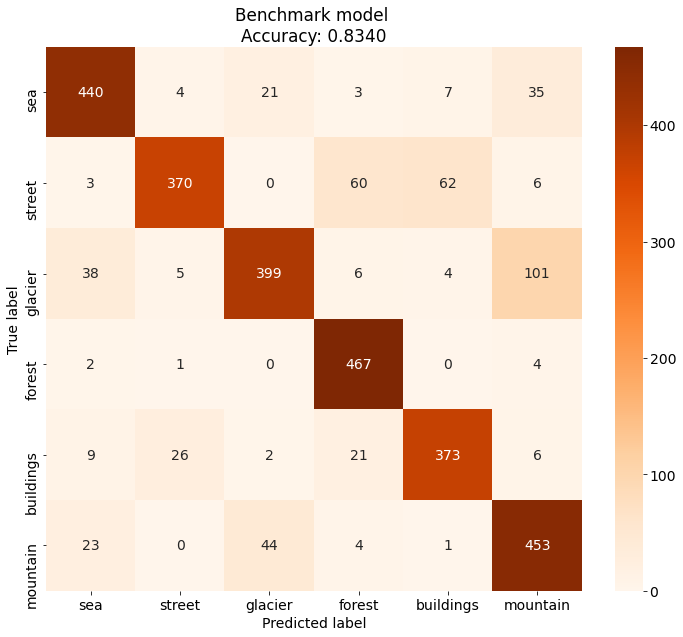

In [30]:
cm = plt.get_cmap('Oranges')

# Creates a confusion matrix
cnf_matr = confusion_matrix(tgt_true, tgt_pred) 

# Transform to df for easier plotting
df = pd.DataFrame(cnf_matr, index=list(CLASSES.values()), columns=list(CLASSES.values()) )

plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=True, fmt="d", cmap=cm)
plt.title('Benchmark model \nAccuracy: {0:.4f}'.format(accuracy_score(tgt_true, tgt_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()